In [1]:
import sys
print(sys.executable)

/Users/mikayla/wallet-wisdom/env-xgboost/bin/python


In [43]:
# dependecies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
# for all my plots
palette = ['#C66F80', '#F4C7D0','#FCEBF1', '#4A6644', '#9FAA74', '#D7DAB3', '#ECE3D2']
customCmap = ListedColormap(palette)

In [4]:
data = pd.read_csv('personalFinanceDataset.csv')
data.head()

,Unnamed: 0,age,gender,raceEthnicity,education,region,householdType,householdSize,career,workArrangement,...,totalExpenses,totalSavingsInvestments,monthlyCashFlow,housingRatio,debtToIncome,savingsInvestmentsRate,carPaymentRatio,monthsSaved,financialHealth,ageCategory
0,0,35,Female,White,High School,South,DINKS,2,Retail,Office,...,5368.49,143.09,-2949.78,66.32,1.33,5.59,0.00,1.17,FinanciallyDistressed,30-35
1,1,65,Female,Black/African American,High School,South,Single,1,Retired,Retired,...,5258.28,0.00,-169.98,25.51,25.51,0.00,13.95,0.07,FinanciallyDistressed,60-65
2,2,50,Male,Other/Multiracial,Bachelor's,Midwest,SingleParent,3,Healthcare,Office,...,6578.61,0.00,-1780.63,37.63,11.88,0.00,8.04,0.93,FinanciallyDistressed,45-50
3,3,40,Female,White,Bachelor's,West,Single,1,Sales,Office,...,7676.07,954.95,-598.56,28.46,14.87,11.89,11.36,1.17,FinanciallyStable,35-40
4,4,30,Male,Black/African American,Some College/Associate's,Midwest,SmallFamily,4,Service,Office,...,7640.68,254.91,-5375.15,57.12,27.03,10.11,15.16,1.37,FinanciallyDistressed,25-30


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 70 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  3500 non-null   int64  
 1   age                         3500 non-null   int64  
 2   gender                      3500 non-null   object 
 3   raceEthnicity               3500 non-null   object 
 4   education                   3500 non-null   object 
 5   region                      3500 non-null   object 
 6   householdType               3500 non-null   object 
 7   householdSize               3500 non-null   int64  
 8   career                      3500 non-null   object 
 9   workArrangement             3500 non-null   object 
 10  annualIncome                3500 non-null   float64
 11  sideHustleIncome            3500 non-null   float64
 12  monthlyIncome               3500 non-null   float64
 13  housingStatus               3500 

In [6]:
data = data.drop(['Unnamed: 0'], axis=1)

In [7]:
data.head()

,age,gender,raceEthnicity,education,region,householdType,householdSize,career,workArrangement,annualIncome,...,totalExpenses,totalSavingsInvestments,monthlyCashFlow,housingRatio,debtToIncome,savingsInvestmentsRate,carPaymentRatio,monthsSaved,financialHealth,ageCategory
0,35,Female,White,High School,South,DINKS,2,Retail,Office,30741.640000,...,5368.49,143.09,-2949.78,66.32,1.33,5.59,0.00,1.17,FinanciallyDistressed,30-35
1,65,Female,Black/African American,High School,South,Single,1,Retired,Retired,61059.581194,...,5258.28,0.00,-169.98,25.51,25.51,0.00,13.95,0.07,FinanciallyDistressed,60-65
2,50,Male,Other/Multiracial,Bachelor's,Midwest,SingleParent,3,Healthcare,Office,57575.730000,...,6578.61,0.00,-1780.63,37.63,11.88,0.00,8.04,0.93,FinanciallyDistressed,45-50
3,40,Female,White,Bachelor's,West,Single,1,Sales,Office,96389.510000,...,7676.07,954.95,-598.56,28.46,14.87,11.89,11.36,1.17,FinanciallyStable,35-40
4,30,Male,Black/African American,Some College/Associate's,Midwest,SmallFamily,4,Service,Office,30245.270000,...,7640.68,254.91,-5375.15,57.12,27.03,10.11,15.16,1.37,FinanciallyDistressed,25-30


In [8]:
data.isnull().sum()

age                       0
gender                    0
raceEthnicity             0
education                 0
region                    0
                         ..
savingsInvestmentsRate    0
carPaymentRatio           0
monthsSaved               0
financialHealth           0
ageCategory               0
Length: 69, dtype: int64

In [9]:
data.duplicated().sum()

0

In [10]:
data.shape

(3500, 69)

In [11]:
# making all categorical values numerical => correlation table (one hot encoding)
ohe_gender = pd.get_dummies(data.gender)
ohe_raceEthnicity = pd.get_dummies(data.raceEthnicity)
ohe_education = pd.get_dummies(data.education)
ohe_region = pd.get_dummies(data.region)
ohe_householdType = pd.get_dummies(data.householdType)
ohe_career = pd.get_dummies(data.career)
ohe_workArrangement = pd.get_dummies(data.workArrangement)
ohe_housingStatus = pd.get_dummies(data.housingStatus)

In [12]:
data = pd.concat([data, ohe_gender, ohe_career, ohe_education, ohe_householdType, ohe_housingStatus, ohe_raceEthnicity, ohe_region, ohe_workArrangement], axis='columns')
data.head()

,age,gender,raceEthnicity,education,region,householdType,householdSize,career,workArrangement,annualIncome,...,White,Midwest,Northeast,South,West,Hybrid,Office,PartTime,Remote,Retired
0,35,Female,White,High School,South,DINKS,2,Retail,Office,30741.640000,...,True,False,False,True,False,False,True,False,False,False
1,65,Female,Black/African American,High School,South,Single,1,Retired,Retired,61059.581194,...,False,False,False,True,False,False,False,False,False,True
2,50,Male,Other/Multiracial,Bachelor's,Midwest,SingleParent,3,Healthcare,Office,57575.730000,...,False,True,False,False,False,False,True,False,False,False
3,40,Female,White,Bachelor's,West,Single,1,Sales,Office,96389.510000,...,True,False,False,False,True,False,True,False,False,False
4,30,Male,Black/African American,Some College/Associate's,Midwest,SmallFamily,4,Service,Office,30245.270000,...,False,True,False,False,False,False,True,False,False,False


writing down some things i want to explore
 1. want to see correlations in different categories
 - more specific one : debt & discretionary
 2. want to see feature importance (which feature has the biggest impact on financial status)
 3. think wanted to learn xg boost model - def want to build a model anyway to simulate real people
 - wanna experiment on lesser features used to train; bc not everyone would have all these numbers ready to go
 4. are there any instances that break the original proportions

In [13]:
df = data[['studentLoans', 'entertainment', 'hobbies', 'travel', 'gifts', 'donations', 'ccPayment', 'personalLoans', 'medicalDebt']].copy()
df.head()

,studentLoans,entertainment,hobbies,travel,gifts,donations,ccPayment,personalLoans,medicalDebt
0,0.0,100.49,0.00,29.91,104.82,0.0,33.95,0.00,0.0
1,0.0,69.68,15.04,52.88,51.07,0.0,588.29,0.00,0.0
2,0.0,43.27,89.37,84.82,105.51,0.0,11.58,172.32,0.0
3,231.8,147.07,0.00,248.83,129.29,0.0,49.99,0.00,0.0
4,0.0,67.81,45.34,25.03,32.54,0.0,299.09,0.00,0.0


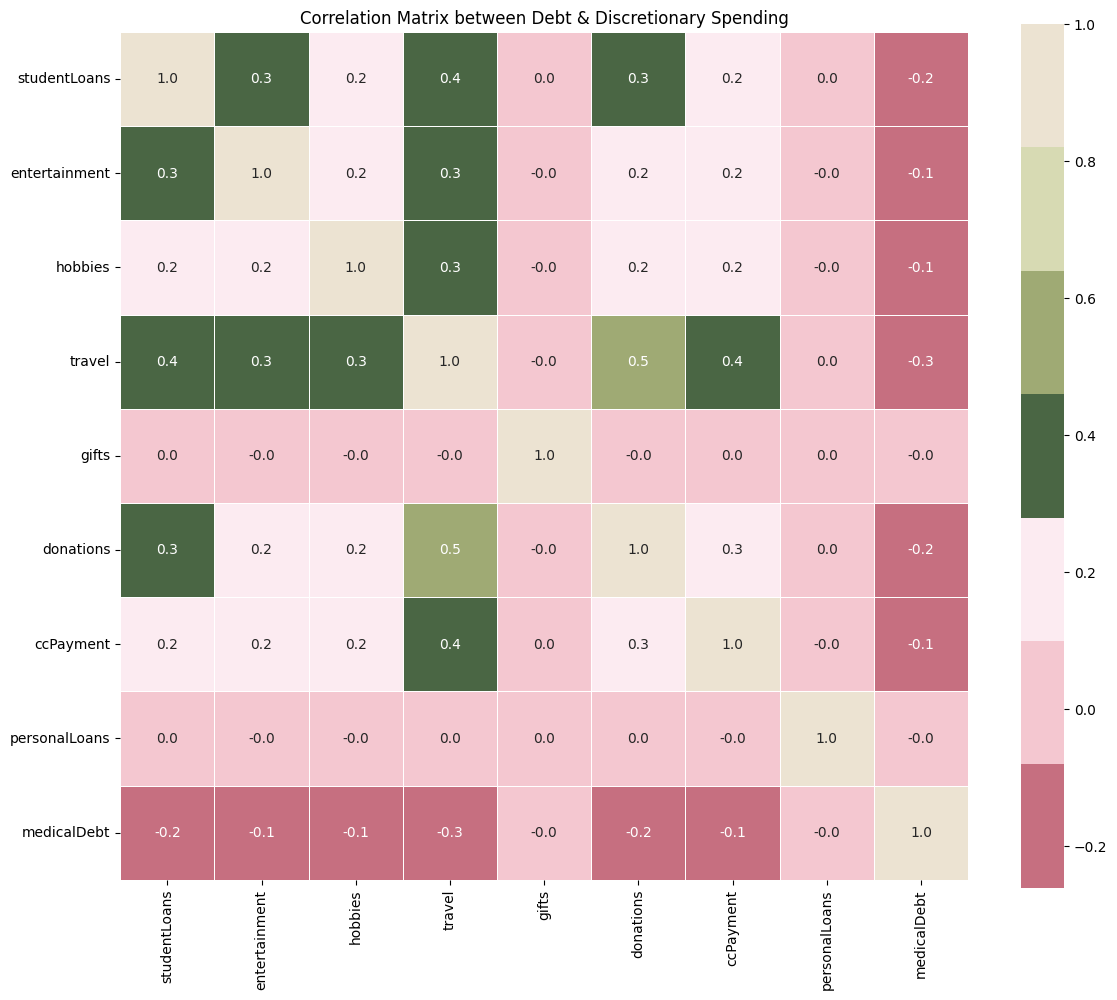

In [14]:
correlationMatrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlationMatrix, annot=True, cmap=customCmap, 
            fmt='.1f', square=True, linewidths=0.5)
plt.title('Correlation Matrix between Debt & Discretionary Spending',)
plt.tight_layout()
plt.show()

In [15]:
# creating some cross tables
crosstab01 = pd.crosstab(data['career'], data['financialHealth'])
crosstab02 = pd.crosstab(data['financialHealth'], data['householdType'])
crosstab03 = pd.crosstab(data['ageCategory'], data['career'])
crosstab04 = pd.crosstab(data['financialHealth'], data['career'])
crosstab04

career,Admin,Business,Construction,Education,Engineering,Finance,FoodService,Healthcare,Legal,Manufacturing,PartTime,Research,Retail,Retired,Sales,Service,Technology,Transportation
financialHealth,,,,,,,,,,,,,,,,,,
FinanciallyDistressed,183,46,88,51,16,12,197,170,1,188,36,0,355,81,83,61,24,112
FinanciallyStable,12,58,4,35,57,50,0,46,11,11,0,1,0,7,30,0,78,3
FinanciallyThriving,0,11,0,7,19,18,0,9,4,0,0,3,0,2,3,0,35,0
FinanciallyVulnerable,116,86,59,100,68,73,34,192,8,126,10,8,83,48,108,24,87,52


<Axes: xlabel='financialHealth'>

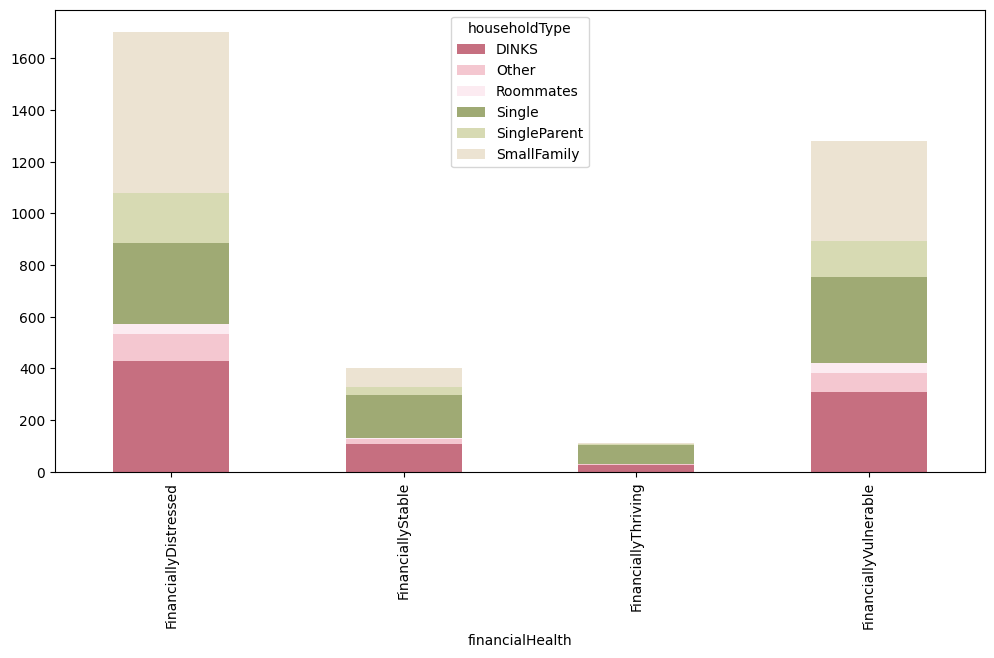

In [16]:
crosstab02.plot(kind='bar', stacked=True, colormap=customCmap, figsize=(12, 6))

MODELING 
1. xg boost 2. knn 3. gan

In [17]:
# about to begin process of using xgboost vastly for feature importance data
# must first label encode y variable
le = LabelEncoder()
y = le.fit_transform(data['financialHealth']) # works for the target variable, not for features

In [18]:
data.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gender           3500 non-null   object
 1   raceEthnicity    3500 non-null   object
 2   education        3500 non-null   object
 3   region           3500 non-null   object
 4   householdType    3500 non-null   object
 5   career           3500 non-null   object
 6   workArrangement  3500 non-null   object
 7   housingStatus    3500 non-null   object
 8   financialHealth  3500 non-null   object
 9   ageCategory      3500 non-null   object
dtypes: object(10)
memory usage: 273.6+ KB


In [31]:
# test train split
x = data.drop(['gender','raceEthnicity', 'education', 'region', 'householdType',
              'career', 'workArrangement', 'housingStatus', 'financialHealth',
              'ageCategory'], axis=1)
featureNames = x.columns
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

In [32]:
yTrain = yTrain.flatten()
yTrain.shape

(2800,)

In [33]:
xTrain = xTrain.astype('float32').values
xTest = xTest.astype('float32').values
yTrain = yTrain.astype('int')

In [34]:
# model
model = XGBClassifier(random_state=42, n_estimators=100, max_depth=4)
model.fit(xTrain, yTrain)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[typing.Callable, str]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [35]:
# evaluate
yPred = model.predict(xTest)
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       321
           1       0.86      0.83      0.84        87
           2       0.88      0.65      0.75        23
           3       0.93      0.98      0.95       269

    accuracy                           0.95       700
   macro avg       0.92      0.86      0.88       700
weighted avg       0.95      0.95      0.95       700



In [36]:
print(le.classes_)

['FinanciallyDistressed' 'FinanciallyStable' 'FinanciallyThriving'
 'FinanciallyVulnerable']


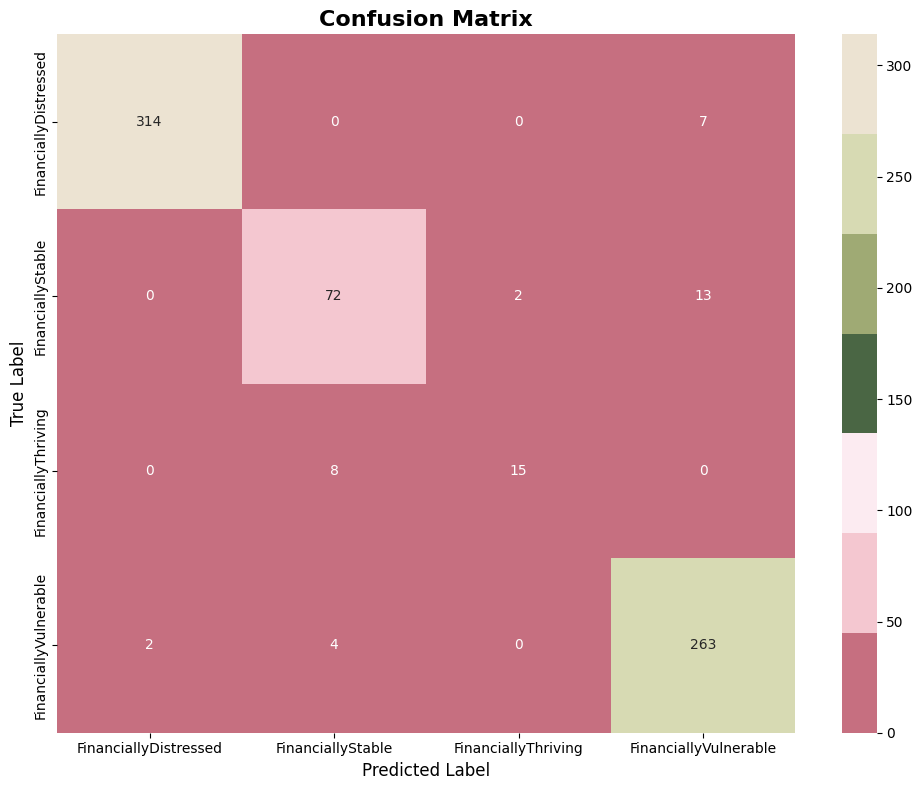

In [37]:
# confusion matrix
cm = confusion_matrix(yTest, yPred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=customCmap, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix', fontsize = 16, fontweight = 'bold')
plt.xlabel('Predicted Label', fontsize = 12)
plt.ylabel('True Label', fontsize = 12)
plt.tight_layout()

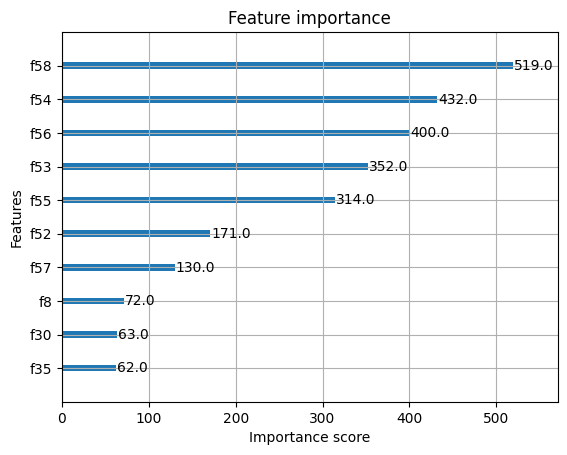

In [38]:
# feature importance
xgb.plot_importance(model, max_num_features=10)
plt.show()

In [39]:
# Get feature importances as a dictionary
importances = model.get_booster().get_score(importance_type='weight')

# Match them to the real column names
feature_map = {f"f{i}": col for i, col in enumerate(featureNames)}

# Translate importances
named_importances = {feature_map.get(k, k): v for k, v in importances.items()}

# Sort and view
import pandas as pd
pd.Series(named_importances).sort_values(ascending=False)

monthsSaved               519.0
housingRatio              432.0
savingsInvestmentsRate    400.0
monthlyCashFlow           352.0
debtToIncome              314.0
                          ...  
Master's                    1.0
Admin                       1.0
Female                      1.0
Midwest                     1.0
publicTransit               1.0
Length: 75, dtype: float64

i want to do a KNN model & test out the differences in my synthetic data made using a python script vs using a GAN and seeing the similarities & differences in the XG Boost & KNN models

In [41]:
# test train split
x = data[['monthsSaved', 'housingRatio', 'savingsInvestmentsRate', 'monthlyCashFlow',
          'debtToIncome', 'totalSavingsInvestments', 'carPaymentRatio', 'homeInsurance',
          'streaming', 'clothing', 'healthInsurance', 'alcohol', 'oopMedical',
          'coffee', 'ccPayment', 'hobbies', 'travel', 'householdSupplies']].copy()
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

In [42]:
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)

In [50]:
kRange = range(5, 10)
cvScores = []

for k in kRange:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, xTrain, yTrain, cv=5, scoring='f1_macro')
    cvScores.append(scores.mean())

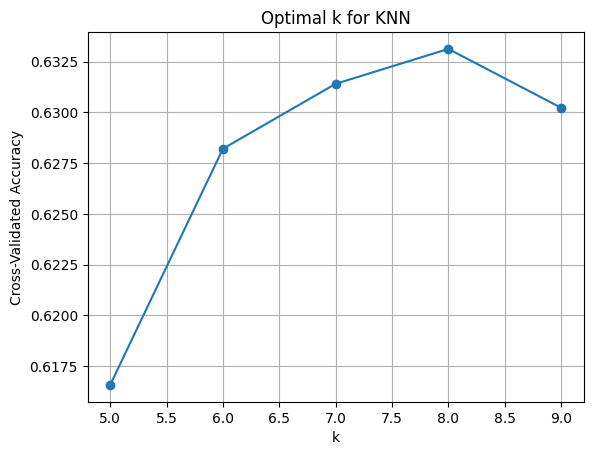

Best k: 8


In [51]:
plt.plot(kRange, cvScores, marker='o')
plt.xlabel('k')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Optimal k for KNN')
plt.grid(True)
plt.show()

best_k = kRange[cvScores.index(max(cvScores))]
print(f"Best k: {best_k}")

In [57]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(xTrain, yTrain)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",9
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [58]:
yPred = knn.predict(xTest)

In [59]:
# evaluate
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       321
           1       0.61      0.39      0.48        87
           2       0.80      0.35      0.48        23
           3       0.69      0.72      0.71       269

    accuracy                           0.74       700
   macro avg       0.73      0.59      0.63       700
weighted avg       0.74      0.74      0.73       700



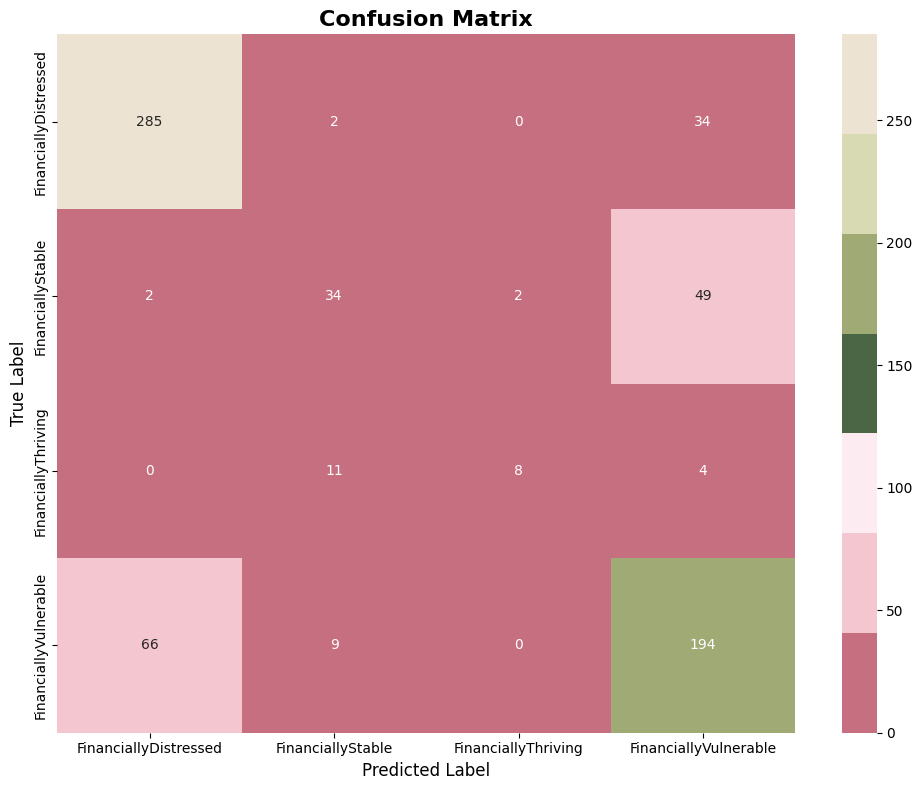

In [60]:
# confusion matrix
cm = confusion_matrix(yTest, yPred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=customCmap, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix', fontsize = 16, fontweight = 'bold')
plt.xlabel('Predicted Label', fontsize = 12)
plt.ylabel('True Label', fontsize = 12)
plt.tight_layout()